In [1]:
import pandas as pd
import numpy  
import tensorflow as tf
import math
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
configpartno='85-EKA0190'

In [2]:
def readTrain():
    train =  pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
    train= train[train['PART_NO']==configpartno]  
    train.drop(columns=['PART_NO','EQP_NO','MFG_MONTH','PM','TS','ENG','NST'],inplace=True)
    train.groupby(['STOCK_EVENT_TIME']).sum().reset_index()
    print(train)
    return train

In [3]:
# LSTM for international airline passengers problem with regression framing

# 產生 (X, Y) 資料集, Y 是下一期的乘客數
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [5]:
# dataframe[dataframe['STOCK_EVENT_TIME'] > '2021-01-01']]
 
# print(dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')].shape)
# print(dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape)

In [6]:

# 載入訓練資料
#dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = readTrain()
dataset = dataframe['QTY']
dataset = dataset.astype('float32')

     STOCK_EVENT_TIME  QTY
3150       2015-01-31    0
3151       2015-02-28    0
3152       2015-03-31    0
3153       2015-04-30    0
3154       2015-05-31    0
...               ...  ...
3745       2020-11-30   15
3746       2020-12-31   20
3747       2021-01-31   15
3748       2021-02-28    5
3749       2021-03-31   15

[600 rows x 2 columns]


In [8]:
dataset =dataset.values.reshape(-1,1)

In [9]:

# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# 2/3 資料為訓練資料， 1/3 資料為測試資料
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size

train_size = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')].shape[0]
# test_size =  dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')].shape[0]
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 產生 (X, Y) 資料集, Y 是下一期的乘客數(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [11]:

# 建立及訓練 LSTM 模型
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=4, input_shape=(1, look_back)),
            tf.keras.layers.Dense(units=1),
            ]) 
model.compile(loss='mean_squared_error', 
            optimizer=tf.keras.optimizers.Adam(),
            # metrics=[tf.keras.metrics.MeanAbsoluteError()]
            ) 
model.summary()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 574 samples
Epoch 1/100
574/574 - 4s - loss: 0.0329
Epoch 2/100
574/574 - 1s - loss: 0.0156
Epoch 3/100
574/574 - 1s - loss: 0.0120
Epoch 4/100
574/574 - 1s - loss: 0.0116
Epoch 5/100
574/574 - 1s - loss: 0.0117
Epoch 6/100
574/574 - 1s - loss: 0.0116
Epoch 7/100
574/574 - 1s - loss: 0.0116
Epoch 8/100
574/574 - 1s - loss: 0.0116
Epoch 9/100
574/574 - 1s - loss: 0.0117
Epoch 10/100
574/574 - 1s - loss: 0.0116
Epoch 11/100
574/574 - 1s - loss: 0.0116
Epoch 12/100
574/574 - 1s - loss: 0.0116
Epoch 13/100
574

In [12]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# nsamples, nx, ny = train_dataset.shape
# d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

In [14]:

# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)

In [15]:
trainY = scaler.inverse_transform([trainY])

In [16]:

testPredict = scaler.inverse_transform(testPredict)

In [17]:


testY = scaler.inverse_transform([testY])

In [18]:
#calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.09 RMSE
Test Score: 8.80 RMSE


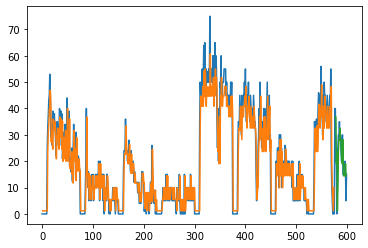

In [19]:

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:


# trainPredictPlot[np.isnan(trainPredictPlot)] = 0  # replace all nan in a with 0
# testPredictPlot[np.isnan(testPredictPlot)] = 0  # replace all nan in b with 0
# numpy.add(trainPredictPlot, testPredictPlot) 
# dataframe_test = dataframe[dataframe['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))<  pd.to_datetime('2021-01-01')]
dataframe_test = dataframe.copy(deep = False)

In [31]:
dataframe_test['Predict'] = testPredictPlot

In [33]:
dataframe_test =  dataframe_test[dataframe_test['STOCK_EVENT_TIME'].apply(lambda x: pd.to_datetime(str(x), format='%Y/%m/%d %H:%M'))>=  pd.to_datetime('2021-01-01')]

In [34]:
def accsum(def_result,target_cols):
        _accsum=0 
        for index,row in def_result.iterrows():
            #避免當分母為0 會無法計算
            if row[target_cols]==0 and row['Predict']==0 :
                row[target_cols] =1
                row['Predict'] =1
            elif row[target_cols] ==0 and row['Predict']!=0:
                row[target_cols]  =0.00001

            if row[target_cols] <0 :
                row[target_cols]  =0.00001

            if row['Predict'] <0 :
                row['Predict']  =0 

            if 1- abs((row['Predict'] - row[target_cols])/row[target_cols] ) >0 : 
                _accsum+=(1- abs((row['Predict'] - row[target_cols])/row[target_cols] ))
        
        return round(_accsum*100/def_result.shape[0],2)

In [35]:
accsum(dataframe_test,'QTY')

3.04

In [36]:
dataframe_test

,STOCK_EVENT_TIME,QTY,Predict
3222,2021-01-31,21,NaN
3223,2021-02-28,17,NaN
3224,2021-03-31,17,NaN
3297,2021-01-31,5,NaN
3298,2021-02-28,5,NaN
3299,2021-03-31,5,NaN
3372,2021-01-31,9,NaN
3373,2021-02-28,0,NaN
3374,2021-03-31,5,NaN
3447,2021-01-31,5,NaN
